
> 비디오 데이터에서 CNN을 사용해 특징을 추출하고, GRU 기반의 RNN 모델로 시퀀스 데이터를 학습하여 행동 인식을 수행하는 프로젝트



# Video Classification with a CNN-RNN Architecture

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/05/28<br>
**Last modified:** 2023/12/08<br>
**Description:** Training a video classifier with transfer learning and a recurrent model on the UCF101 dataset.

This example demonstrates video classification, an important use-case with
applications in recommendations, security, and so on.
We will be using the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php)
to build our video classifier. The dataset consists of videos categorized into different
actions, like cricket shot, punching, biking, etc. This dataset is commonly used to
build action recognizers, which are an application of video classification.

A video consists of an ordered sequence of frames. Each frame contains *spatial*
information, and the sequence of those frames contains *temporal* information. To model
both of these aspects, we use a hybrid architecture that consists of convolutions
(for spatial processing) as well as recurrent layers (for temporal processing).
Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural
Network (RNN) consisting of [GRU layers](https://keras.io/api/layers/recurrent_layers/gru/).
This kind of hybrid architecture is popularly known as a **CNN-RNN**.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Data collection

In order to keep the runtime of this example relatively short, we will be using a
subsampled version of the original UCF101 dataset. You can refer to
[this notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb)
to know how the subsampling was done.

In [ ]:
!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Setup

In [ ]:
import os

import keras
from imutils import paths

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2 # OpenCV를 사용해 이미지 처리
from IPython.display import Image # Jupyter 노트북에서 이미지를 출력하기 위한 모듈

## Define hyperparameters

In [ ]:
IMG_SIZE = 224 # 이미지 크기를 224x224로 고정
BATCH_SIZE = 64 # 한 번에 처리할 데이터 수
EPOCHS = 10  # 모델을 10번 학습

# 시퀀스 길이 및 특징 수 설정
MAX_SEQ_LENGTH = 20  # 비디오에서 사용할 최대 프레임 수
NUM_FEATURES = 2048  # CNN을 통해 추출될 특징 벡터의 크기

모델 훈련 시 사용할 이미지 크기, 배치 크기, 에포크 설정

## Data preparation

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
525,v_TennisSwing_g15_c01.avi,TennisSwing
120,v_PlayingCello_g08_c03.avi,PlayingCello
341,v_Punch_g23_c04.avi,Punch
326,v_Punch_g21_c03.avi,Punch
479,v_TennisSwing_g08_c03.avi,TennisSwing
457,v_ShavingBeard_g23_c01.avi,ShavingBeard
196,v_PlayingCello_g19_c06.avi,PlayingCello
149,v_PlayingCello_g12_c05.avi,PlayingCello
119,v_PlayingCello_g08_c02.avi,PlayingCello
249,v_Punch_g09_c05.avi,Punch


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('tag').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

One of the many challenges of training video classifiers is figuring out a way to feed
the videos to a network. [This blog post](https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5)
discusses five such methods. Since a video is an ordered sequence of frames, we could
just extract the frames and put them in a 3D tensor. But the number of frames may differ
from video to video which would prevent us from stacking them into batches
(unless we use padding). As an alternative, we can **save video frames at a fixed
interval until a maximum frame count is reached**. In this example we will do
the following:

1. Capture the frames of a video.
2. Extract frames from the videos until a maximum frame count is reached.
3. In the case, where a video's frame count is lesser than the maximum frame count we
will pad the video with zeros.

Note that this workflow is identical to [problems involving texts sequences](https://developers.google.com/machine-learning/guides/text-classification/). Videos of the UCF101 dataset is [known](https://www.crcv.ucf.edu/papers/UCF101_CRCV-TR-12-01.pdf)
to not contain extreme variations in objects and actions across frames. Because of this,
it may be okay to only consider a few frames for the learning task. But this approach may
not generalize well to other video classification problems. We will be using
[OpenCV's `VideoCapture()` method](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html)
to read frames from videos.

In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]  # 프레임의 높이(y)와 너비(x) 가져오기
    min_dim = min(y, x)  # 가장 작은 변을 기준으로 정사각형을 만듦
    start_x = (x // 2) - (min_dim // 2)  # 중앙에서 시작 x 좌표
    start_y = (y // 2) - (min_dim // 2)  # 중앙에서 시작 y 좌표
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]  # 자른 정사각형 프레임 반환


# 데이터를 비디오 시퀀스로 처리하는 함수 정의
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)  # 비디오 파일을 읽어오기 위해 OpenCV의 VideoCapture 사용
    frames = []  # 비디오 프레임을 저장할 리스트
    try:
        while True:
            ret, frame = cap.read()  # 프레임을 읽음 (ret는 성공 여부, frame은 프레임 데이터)
            if not ret:
                break  # 프레임을 더 이상 읽을 수 없으면 종료

            frame = crop_center_square(frame)  # 중앙 정사각형으로 자름
            frame = cv2.resize(frame, resize)  # 프레임 크기를 지정한 크기로 변경 (224x224)
            frame = frame[..., [2, 1, 0]]  # BGR에서 RGB로 색상 순서 변경 (OpenCV는 기본적으로 BGR 사용)
            frames.append(frame)  # 프레임을 리스트에 추가

            if len(frames) == max_frames:  # 최대 프레임 수에 도달하면 루프 종료
                break
    finally:
        cap.release()  # 비디오 캡처 객체 해제

    return np.array(frames)  # 프레임 배열을 반환


We can use a pre-trained network to extract meaningful features from the extracted
frames. The [`Keras Applications`](https://keras.io/api/applications/) module provides
a number of state-of-the-art models pre-trained on the [ImageNet-1k dataset](http://image-net.org/).
We will be using the [InceptionV3 model](https://arxiv.org/abs/1512.00567) for this purpose.

In [ ]:
# 특징 추출기 모델을 빌드하는 함수 정의
def build_feature_extractor():
    # InceptionV3 모델을 사전 훈련된 Imagenet 가중치로 로드 (전이 학습을 위해)
    # include_top=False는 최상단 분류 층을 제외하고, pooling="avg"는 global average pooling을 추가하여 출력 벡터를 압축
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",  # 사전 훈련된 Imagenet 가중치를 사용
        include_top=False,  # 최종 분류 레이어를 제외 (우리는 자체 분류 레이어를 추가할 예정)
        pooling="avg",  # global average pooling을 사용하여 특징 벡터를 하나로 압축
        input_shape=(IMG_SIZE, IMG_SIZE, 3),  # 입력 이미지 크기는 224x224 픽셀, 3채널(RGB) 사용
    )

    # InceptionV3 모델에 필요한 전처리 함수를 설정 (모델에 맞게 이미지를 전처리)
    preprocess_input = keras.applications.inception_v3.preprocess_input

    # 입력 레이어 정의: 224x224 크기의 RGB 이미지 입력
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))

    # 입력 데이터를 InceptionV3 모델에서 요구하는 형식으로 전처리
    preprocessed = preprocess_input(inputs)

    # 전처리된 입력 데이터를 특징 추출기로 전달하여 특징 벡터 추출
    outputs = feature_extractor(preprocessed)

    # 입력과 출력을 연결하여 특징 추출 모델 생성 및 반환
    return keras.Model(inputs, outputs, name="feature_extractor")

# 특징 추출기 모델을 생성 (build_feature_extractor 함수 호출)
feature_extractor = build_feature_extractor()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


The labels of the videos are strings. Neural networks do not understand string values,
so they must be converted to some numerical form before they are fed to the model. Here
we will use the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer encode the class labels as integers.

In [ ]:
# 라벨을 처리하는 레이어를 정의
label_processor = keras.layers.StringLookup(
    num_oov_indices=0,  # OOV(Out of Vocabulary) 토큰의 인덱스를 0으로 설정 (범위 밖의 라벨이 없다는 의미)
    vocabulary=np.unique(train_df["tag"])  # 학습 데이터에서 고유한 태그(라벨) 리스트를 사전으로 설정
)

# 라벨 처리기에 저장된 어휘(vocabulary)를 출력
print(label_processor.get_vocabulary())


['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


이 코드는 StringLookup 레이어를 사용하여 비디오 분류에서 태그(라벨)를 인덱스로 변환합니다. vocabulary 파라미터는 학습 데이터셋에서 고유한 태그를 기반으로 정의되고, num_oov_indices=0은 사전에 없는 라벨을 허용하지 않겠다는 의미입니다. get_vocabulary() 메소드를 사용하여 설정된 라벨 목록을 확인할 수 있습니다.

Finally, we can put all the pieces together to create our data processing utility.

In [ ]:
# 모든 비디오 데이터를 처리하는 함수 정의
def prepare_all_videos(df, root_dir):
    num_samples = len(df)  # 데이터프레임에 있는 비디오 샘플 수
    video_paths = df["video_name"].values.tolist()  # 비디오 파일 이름 리스트
    labels = df["tag"].values  # 각 비디오에 해당하는 태그(라벨)

    # 라벨을 인덱스로 변환 (StringLookup 레이어 사용)
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # 시퀀스 모델에 입력될 데이터
    # frame_masks는 시퀀스가 패딩된 타임스텝인지 여부를 나타내는 부울 값을 포함
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")  # 패딩 여부를 나타내는 마스크
    # frame_features는 각 비디오 프레임에 대한 특징 벡터를 저장
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # 각 비디오에 대해 처리
    for idx, path in enumerate(video_paths):
        # 비디오에서 모든 프레임을 가져오고, 배치 차원을 추가
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]  # 배치 차원 추가

        # 현재 비디오의 마스크와 특징을 저장할 플레이스홀더 초기화
        temp_frame_mask = np.zeros(
            shape=(1, MAX_SEQ_LENGTH), dtype="bool"  # 마스크를 위한 배열
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"  # 특징 벡터를 위한 배열
        )

        # 현재 비디오의 프레임에서 특징 추출
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]  # 비디오의 전체 프레임 길이
            length = min(MAX_SEQ_LENGTH, video_length)  # 최대 시퀀스 길이와 비디오 길이 중 작은 값 선택
            for j in range(length):
                # 특징 추출기 모델을 통해 각 프레임에서 특징을 추출하여 저장
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,  # 추론 중 로그 출력을 끄기 위해 verbose=0 사용
                )
            temp_frame_mask[i, :length] = 1  # 프레임 길이만큼 마스크를 1로 설정 (1 = 패딩되지 않음)

        # 추출된 프레임 특징과 마스크를 최종 배열에 저장
        frame_features[idx,] = temp_frame_features.squeeze()  # 차원 축소하여 저장
        frame_masks[idx,] = temp_frame_mask.squeeze()

    # 비디오 특징과 마스크, 라벨을 반환
    return (frame_features, frame_masks), labels

# 학습 데이터셋을 준비 (train_df에서 비디오 데이터와 라벨을 준비)
train_data, train_labels = prepare_all_videos(train_df, "train")

# 테스트 데이터셋을 준비 (test_df에서 비디오 데이터와 라벨을 준비)
test_data, test_labels = prepare_all_videos(test_df, "test")

# 학습 데이터셋의 프레임 특징 및 마스크 크기를 출력
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")


Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


비디오 로드 및 특징 추출: 각 비디오의 프레임을 load_video()를 통해 가져오고, feature_extractor를 사용해 각 프레임에 대한 CNN 특징을 추출합니다.

패딩 및 마스킹: 시퀀스의 길이가 최대 프레임 길이를 넘지 않도록 하고, 부족한 프레임은 0으로 패딩합니다. frame_masks는 실제 프레임과 패딩된 부분을 구분하기 위한 부울 배열입니다.

특징 및 라벨 반환: 처리된 프레임 특징, 마스크, 라벨을 모델 훈련을 위해 반환합니다.
이 과정에서 학습 및 테스트 데이터셋의 특징과 마스크 배열의 크기를 확인합니다.

The above code block will take ~20 minutes to execute depending on the machine it's being
executed.

## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [ ]:
# 시퀀스 모델을 정의하는 함수
def get_sequence_model():
    # 라벨 처리기에서 사용하는 라벨(클래스)의 어휘 목록 가져오기
    class_vocab = label_processor.get_vocabulary()

    # 입력 레이어 정의: 프레임 특징 입력 (MAX_SEQ_LENGTH 시퀀스 길이, NUM_FEATURES는 각 프레임의 특징 수)
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    # 마스크 입력: 시퀀스 내의 패딩된 부분을 구분하기 위한 부울 입력 (MAX_SEQ_LENGTH만큼)
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # 시퀀스 모델의 중요성을 설명하는 튜토리얼 참조 (GRU 레이어에서 마스크 입력 사용)
    # https://keras.io/api/layers/recurrent_layers/gru/
    # 첫 번째 GRU 레이어: 16개의 유닛, 시퀀스 전체를 반환 (return_sequences=True)
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input  # 마스크를 통해 패딩된 부분을 무시
    )
    # 두 번째 GRU 레이어: 8개의 유닛, 마지막 출력만 반환 (return_sequences=False)
    x = keras.layers.GRU(8)(x)
    # Dropout 레이어: 40%의 드롭아웃 비율로 과적합 방지
    x = keras.layers.Dropout(0.4)(x)
    # Dense 레이어: 8개의 유닛, ReLU 활성화 함수 사용
    x = keras.layers.Dense(8, activation="relu")(x)
    # 출력 레이어: 클래스 수만큼의 유닛, 소프트맥스 활성화 함수 사용 (클래스 확률 출력)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    # 입력과 출력을 연결하여 모델 생성
    rnn_model = keras.Model([frame_features_input, mask_input], output)

    # 모델 컴파일: 손실 함수는 sparse_categorical_crossentropy, 옵티마이저는 Adam, 평가 지표는 정확도
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model  # 시퀀스 모델 반환


# 실험을 실행하는 함수
def run_experiment():
    # 체크포인트 파일 경로 설정 (최적의 가중치만 저장)
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    # 체크포인트 콜백 설정: 최상의 모델 가중치만 저장하도록 설정
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    # 시퀀스 모델 생성
    seq_model = get_sequence_model()

    # 모델 훈련: 학습 데이터로 훈련, 검증 데이터는 30%로 분할, 에포크 수만큼 학습
    history = seq_model.fit(
        [train_data[0], train_data[1]],  # 입력: 프레임 특징과 마스크
        train_labels,  # 라벨
        validation_split=0.3,  # 검증 데이터 비율 (30%)
        epochs=EPOCHS,  # 에포크 수
        callbacks=[checkpoint],  # 체크포인트 콜백 사용
    )

    # 체크포인트에서 최적의 모델 가중치 로드
    seq_model.load_weights(filepath)

    # 테스트 데이터셋에서 모델 평가
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")  # 테스트 정확도 출력

    return history, seq_model  # 학습 기록과 훈련된 모델 반환


# 실험 실행
_, sequence_model = run_experiment()


Epoch 1/10
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3328 - loss: 1.5089
Epoch 1: val_loss improved from inf to 1.82319, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.3474 - loss: 1.4776 - val_accuracy: 0.1397 - val_loss: 1.8232
Epoch 2/10
 7/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5270 - loss: 1.1620
Epoch 2: val_loss improved from 1.82319 to 1.63802, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5599 - loss: 1.1165 - val_accuracy: 0.2179 - val_loss: 1.6380
Epoch 3/10
 7/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6938 - loss: 0.9380 
Epoch 3: val_loss did not improve from 1.63802
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6863 - loss: 0.9367 - val_accuracy: 0.2402 - val_loss: 1.6961
Epoch 4/10
 7/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6635 - loss: 0.8890 
Epoch 4: val_loss improved from 1.63802 to 1.56721, savin

get_sequence_model:시퀀스 모델을 정의하는 함수입니다. 이 함수는 두 개의 GRU 레이어와 드롭아웃, 두 개의 Dense 레이어로 구성된 모델을 반환합니다. 시퀀스 데이터를 처리할 때 마스크 입력을 통해 패딩된 부분을 무시하도록 합니다.
최종 출력은 소프트맥스 활성화 함수로 클래스 확률을 반환합니다.

run_experiment: 이 함수는 모델을 훈련하고, 최적의 가중치를 저장한 후, 테스트 데이터셋에서 성능을 평가합니다.
체크포인트 콜백을 사용해 최적의 모델 가중치를 저장하며, 훈련 후 이를 불러와 테스트 정확도를 계산합니다.

**Note**: To keep the runtime of this example relatively short, we just used a few
training examples. This number of training examples is low with respect to the sequence
model being used that has 99,909 trainable parameters. You are encouraged to sample more
data from the UCF101 dataset using [the notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb) mentioned above and train the same model.

## Inference

Test video path: v_CricketShot_g01_c05.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
  CricketShot: 33.61%
  ShavingBeard: 24.17%
  PlayingCello: 14.20%
  TennisSwing: 14.15%
  Punch: 13.87%


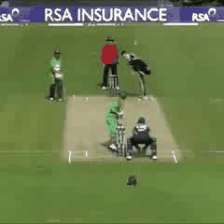

In [ ]:
# 단일 비디오 데이터를 처리하는 함수
def prepare_single_video(frames):
    frames = frames[None, ...]  # 배치 차원을 추가 (모델이 배치 형태로 입력을 받기 때문에)

    # 마스크 배열을 초기화: 1 = 실제 데이터, 0 = 패딩된 데이터
    frame_mask = np.zeros(
        shape=(1, MAX_SEQ_LENGTH),  # 시퀀스 길이만큼 부울 배열 생성
        dtype="bool",
    )

    # 프레임 특징을 저장할 배열 초기화 (NUM_FEATURES는 CNN을 통해 추출한 특징 벡터의 크기)
    frame_features = np.zeros(
        shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # 각 비디오 프레임에서 특징을 추출
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]  # 비디오의 총 프레임 수
        length = min(MAX_SEQ_LENGTH, video_length)  # 시퀀스 길이를 넘어가지 않도록 프레임 수 제한
        for j in range(length):
            # 특징 추출 모델을 사용해 각 프레임에서 CNN 특징을 추출
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 사용된 프레임은 마스크를 1로 설정 (패딩되지 않음)

    return frame_features, frame_mask  # 추출된 프레임 특징과 마스크 반환


# 시퀀스 예측 함수 정의
def sequence_prediction(path):
    # 라벨 처리기에서 클래스 어휘 가져오기
    class_vocab = label_processor.get_vocabulary()

    # 비디오 로드
    frames = load_video(os.path.join("test", path))

    # 단일 비디오 프레임 처리
    frame_features, frame_mask = prepare_single_video(frames)

    # 모델을 사용하여 예측
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    # 확률을 정렬하여 높은 순으로 출력
    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    return frames  # 비디오 프레임 반환


# 시각화를 위한 유틸리티 함수 (비디오를 GIF로 변환)
# 참조: https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    # 이미지를 uint8 형식으로 변환
    converted_images = images.astype(np.uint8)

    # GIF 파일 생성 (imageio.mimsave 사용)
    imageio.mimsave("animation.gif", converted_images, duration=100)

    # GIF 파일을 Jupyter에서 출력하기 위한 Image 객체 반환
    return Image("animation.gif")


# 테스트 비디오를 무작위로 선택
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")

# 선택한 비디오로 예측 실행
test_frames = sequence_prediction(test_video)

# 예측된 비디오의 첫 MAX_SEQ_LENGTH 프레임을 GIF로 변환하여 시각화
to_gif(test_frames[:MAX_SEQ_LENGTH])


prepare_single_video:

이 함수는 단일 비디오의 프레임을 처리하고, CNN을 통해 각 프레임의 특징을 추출한 후, 이를 시퀀스 모델에 맞는 형태로 변환합니다. 시퀀스의 마스크(frame_mask)도 함께 반환합니다.

sequence_prediction: 지정된 경로에 있는 테스트 비디오를 처리하고, 시퀀스 모델을 사용해 예측한 각 클래스의 확률을 출력합니다. 클래스 확률은 높은 순서대로 정렬하여 출력합니다.

to_gif: 비디오 프레임을 GIF로 변환하는 유틸리티 함수로, 이미지 배열을 imageio 라이브러리를 사용해 GIF로 저장하고, Jupyter 노트북에서 GIF 파일을 시각적으로 출력할 수 있도록 합니다.

실험 실행:무작위로 테스트 비디오를 선택하여 예측을 수행하고, 선택된 비디오의 첫 MAX_SEQ_LENGTH 프레임을 GIF로 변환하여 시각화합니다.

## Next steps

* In this example, we made use of transfer learning for extracting meaningful features
from video frames. You could also fine-tune the pre-trained network to notice how that
affects the end results.
* For speed-accuracy trade-offs, you can try out other models present inside
`keras.applications`.
* Try different combinations of `MAX_SEQ_LENGTH` to observe how that affects the
performance.
* Train on a higher number of classes and see if you are able to get good performance.
* Following [this tutorial](https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub), try a
[pre-trained action recognition model](https://arxiv.org/abs/1705.07750) from DeepMind.
* Rolling-averaging can be useful technique for video classification and it can be
combined with a standard image classification model to infer on videos.
[This tutorial](https://www.pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/)
will help understand how to use rolling-averaging with an image classifier.
* When there are variations in between the frames of a video not all the frames might be
equally important to decide its category. In those situations, putting a
[self-attention layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) in the
sequence model will likely yield better results.
* Following [this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11),
you can implement Transformers-based models for processing videos.

1. 데이터 준비
사용된 함수:

*   load_video(): 비디오 파일을 읽어와 프레임으로 변환.
*   prepare_all_videos(): 데이터셋 내 모든 비디오에 대해 프레임 특징 추출 및 마스크 생성.

*   prepare_single_video(): 단일 비디오를 처리하여 프레임 특징과 마스크 생성.
*   frames_to_tensor(): 비디오 프레임의 수를 시퀀스 길이에 맞추는 작업을 수행.


---


2. 시퀀스 모델 구성
사용된 함수:


*   get_sequence_model(): 시퀀스 모델(GRU 기반)을 구성. CNN에서 추출한 프레임 특징을 입력으로 받아 행동을 예측하는 모델을 정의.



---


3. 모델 훈련 및 평가
사용된 함수:


*   run_experiment(): 모델을 훈련하고, 최적의 가중치를 저장하며, 테스트 데이터로 모델 성능을 평가.
*   get_sequence_model(): 위에서 정의한 시퀀스 모델을 호출해 훈련에 사용.


---


4. 단일 비디오 예측
사용된 함수:


*   sequence_prediction(): 단일 비디오 파일을 로드하고, 모델을 통해 해당 비디오가 어떤 클래스에 속하는지 예측.
*   prepare_single_video(): 예측할 비디오의 프레임을 CNN을 통해 특징으로 변환하고 시퀀스 모델에 맞는 형식으로 준비.

*   to_gif(): 예측된 비디오의 프레임을 GIF로 변환하여 시각화.







